In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from seaborn import heatmap
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
import re
import operator
%matplotlib inline

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
good_aliases = pd.read_csv('aliases/goods.csv', header=None)
good_terms = good_aliases[0].tolist()

In [3]:
# Load data
df = pd.read_csv('csv/metadata_text_merged_cleaned.csv')
texts = df['text_cleaned_dealiased'].tolist()

In [4]:
# Create dictionary of dictionaries corresponding to pairs of items
item_pair_counts = {}

for good_name in good_terms:
    item_pair_counts[good_name] = {}
    
for key in item_pair_counts.keys():
    for good_name in good_terms:
        item_pair_counts[key][good_name] = 0

In [5]:
# Iterate over texts and fill in matrix
for text in tqdm_notebook(texts):
    # Boolean dict of dicts for explored pairs
    explored = {}
    
    for good_name in good_terms:
        explored[good_name] = {}
    
    for key in explored.keys():
        for good_name in good_terms:
            explored[key][good_name] = False
    
    
    for good1 in good_terms:
        for good2 in good_terms:
            if good1 != good2:
                if explored[good1][good2] is False and explored[good2][good1] is False and good1 in text and good2 in text:
                    # Update counts
                    item_pair_counts[good1][good2] += 1
                    item_pair_counts[good2][good1] += 1
                    
                    # Mark as explored
                    explored[good1][good2] = True
                    explored[good2][good1] = True

A Jupyter Widget

In [6]:
count_matrix = pd.DataFrame(item_pair_counts)

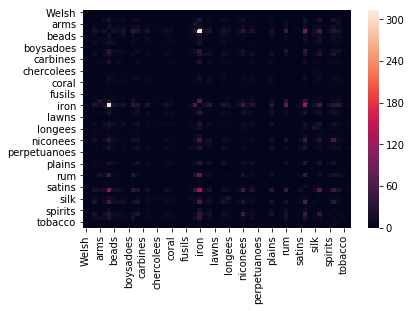

In [7]:
heatmap(count_matrix)

In [8]:
pair_freq = {}

for key1 in item_pair_counts:
    for key2 in item_pair_counts[key1]:
        if key1 != key2 and '{}-{}'.format(key2, key1) not in pair_freq.keys():
            pair_freq['{}-{}'.format(key1, key2)] = item_pair_counts[key1][key2]

In [13]:
sorted(pair_freq.items(), key=operator.itemgetter(1), reverse=True)[:100]

[('bars-iron', 313),
 ('says-iron', 126),
 ('bars-says', 94),
 ('rum-iron', 73),
 ('guns-iron', 63),
 ('says-sletias', 59),
 ('sletias-iron', 55),
 ('bars-sletias', 53),
 ('tapseils-niconees', 51),
 ('bars-rum', 50),
 ('says-niconees', 49),
 ('niconees-iron', 48),
 ('tapseils-says', 47),
 ('says-rum', 47),
 ('says-guns', 41),
 ('brandy-iron', 40),
 ('tapseils-sletias', 39),
 ('says-brandy', 39),
 ('times-iron', 39),
 ('bars-brandy', 37),
 ('bars-niconees', 36),
 ('tapseils-iron', 36),
 ('plains-iron', 34),
 ('says-plains', 33),
 ('knives-iron', 33),
 ('rum-brandy', 31),
 ('bars-tapseils', 31),
 ('longcloths-iron', 30),
 ('rum-guns', 30),
 ('pautkaes-iron', 30),
 ('sletias-niconees', 29),
 ('says-brawls', 29),
 ('tapseils-brawls', 28),
 ('bars-guns', 28),
 ('iron-brawls', 28),
 ('arms-guns', 28),
 ('allejars-iron', 27),
 ('says-times', 27),
 ('longees-silk', 27),
 ('iron-carpets', 27),
 ('sletias-brawls', 27),
 ('bars-knives', 26),
 ('sletias-allejars', 25),
 ('bars-brawls', 25),
 ('bea

In [30]:
# Export pair frequencies to csv
pair_freq_df = pd.DataFrame(pair_freq.items(), columns=['pair', 'frequency'])
pair_freq_df.to_csv('csv/pair_freq.csv', index=False)

# Market Basket Analysis

In [55]:
good_list = [] + ['kettles']

# Get list of lists for good occurrences
for i, row in df.iterrows():
    goods = []
    
    for good_name in good_terms:
        if good_name != 'says' and good_name != 'bars' and good_name in row['text_cleaned_dealiased'].split():
            goods.append(good_name)
    
    good_list.append(goods)
    

In [56]:
# One hot encode goods over all texts
te = TransactionEncoder()
te_ary = te.fit(good_list).transform(good_list)
good_oh = pd.DataFrame(te_ary, columns=te.columns_)

In [78]:
frequent_itemsets = apriori(good_oh, min_support=0.004, use_colnames=True)

In [79]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [80]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(plains),(pautkaes),0.039793,0.024264,0.005176,0.130081,5.361084,0.004211,1.121640
1,(pautkaes),(plains),0.024264,0.039793,0.005176,0.213333,5.361084,0.004211,1.220602
2,(knives),(rum),0.041734,0.065675,0.004529,0.108527,1.652499,0.001788,1.048069
3,(rum),(knives),0.065675,0.041734,0.004529,0.068966,1.652499,0.001788,1.029249
4,(brawls),(knives),0.030087,0.041734,0.004853,0.161290,3.864716,0.003597,1.142548
5,(knives),(brawls),0.041734,0.030087,0.004853,0.116279,3.864716,0.003597,1.097533
6,(allejars),(brawls),0.019735,0.030087,0.004206,0.213115,7.083201,0.003612,1.232597
7,(brawls),(allejars),0.030087,0.019735,0.004206,0.139785,7.083201,0.003612,1.139558
8,(brawls),(niconees),0.030087,0.054028,0.006470,0.215054,3.980426,0.004845,1.205143
9,(niconees),(brawls),0.054028,0.030087,0.006470,0.119760,3.980426,0.004845,1.101874


In [39]:
# High confidence and high lift
rules[ (rules['lift'] > 1) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [65]:
rules[ (rules['lift'] > 3)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(plains),(knives),0.039793,0.041734,0.005500,0.138211,3.311716,0.003839,1.111950
3,(knives),(plains),0.041734,0.039793,0.005500,0.131783,3.311716,0.003839,1.105953
4,(brawls),(tapseils),0.030087,0.045940,0.009059,0.301075,6.553688,0.007676,1.365040
5,(tapseils),(brawls),0.045940,0.030087,0.009059,0.197183,6.553688,0.007676,1.208137
6,(sletias),(plains),0.055969,0.039793,0.007117,0.127168,3.195733,0.004890,1.100105
7,(plains),(sletias),0.039793,0.055969,0.007117,0.178862,3.195733,0.004890,1.149662
10,(sletias),(tapseils),0.055969,0.045940,0.012617,0.225434,4.907148,0.010046,1.231734
11,(tapseils),(sletias),0.045940,0.055969,0.012617,0.274648,4.907148,0.010046,1.301480
14,(longees),(silk),0.016176,0.011970,0.008412,0.520000,43.441081,0.008218,2.058395
15,(silk),(longees),0.011970,0.016176,0.008412,0.702703,43.441081,0.008218,3.309226


In [83]:
rules.to_csv('csv/market_basket.csv', index=False)